In [1]:
import time
from matplotlib import pyplot as plt
import numpy as np
import pyvisa as visa
import pickle

In [2]:
np.set_printoptions(threshold=8)

def set_osc_acq(osc):
    # Configuración de la adquisición de curvas
    osc.write('DAT:ENC RPB')
    osc.write('DAT:WID 1')
    osc.write('DAT:STAR 1')
    osc.write('DAT:STOP 2500')
    osc.write('ACQ:MOD SAMP')

def parse_parameters(wfmp_params):
    """Parsea la información de configuración de las escalas y las almacena en un diccionario.
    Para después simplificar el gráfico de la curva."""
    result = {}
    header_def = [('BYT_Nr', int),
              ('BiT_Nr', int),
              ('ENCdg', str),
              ('BN_Fmt', str),
              ('BYT_Or', str)]
    wfrm1_def = [('WFID', str),
             ('NR_PT', int),
             ('PT_FMT', str),
             ('XUNIT', str),
             ('XINCR', float),
             ('PT_Off', int),
             ('YUNIT', str),
             ('YMULT', float),
             ('YOFf', float),
             ('YZEro', float)]

    full_def = header_def + [(f'wfm1:{k}', c) for k, c in wfrm1_def] \
           + [(f'wfm2:{k}', c) for k, c in wfrm1_def] \
           + [(f'wfm3:{k}', c) for k, c in wfrm1_def] \
           + [(f'wfm4:{k}', c) for k, c in wfrm1_def]
    for (key, conversor), param in zip(full_def, wfmp_params.split(';')):
        result[key] = conversor(param)
    return result

def escalar_curva(data, parametros):
    """Devuelve el par de vectores (t, v) a partir de la curva levantada del osciloscopio
    y los parámetros de escala del mismo. El eje temporal está en ms y el vertical en Volts/"""
    n = len(data)
    t = 1e3 * (np.arange(n) - parametros['wfm1:PT_Off']) * parametros['wfm1:XINCR']

    v = (data - parametros['wfm1:YOFf']) * parametros['wfm1:YMULT'] \
                    + parametros['wfm1:YZEro']
    return t, v


In [5]:
#%%
# inicializo comunicacion con equipos
rm = visa.ResourceManager()

# lista de dispositivos conectados, para ver las id de los equipos
print(rm.list_resources())

('GPIB0::1::INSTR', 'GPIB0::7::INSTR')


In [6]:
# Abrimos el recurso de VISA, en este caso es un osciloscopio
osc = rm.open_resource('GPIB0::7::INSTR')

print(osc.query("HOR?"))
set_osc_acq(osc)

# osc.write('DAT:SOU CH1') # Adquirimos del canal 1
# # La lectura se puede hacer en modo binario, lo que la hace más eficiente
# conf_parameters_a = parse_parameters(osc.query('WFMP?'))
# data_a = osc.query_binary_values('CURV?', datatype='B', container=np.array)
# data_a

# # Cambiamos la escala temporal y volvemos a adquirir
# scale = '250e-6'
# osc.write(f'HOR:SCA {scale}')
# conf_parameters_b = parse_parameters(osc.query('WFMP?'))
# data_b = osc.query_binary_values('CURV?', datatype='B', container=np.array)
# data_b



# plt.rcParams['font.size'] = '16'
# t_a, v_a = escalar_curva(data_a, conf_parameters_a)
# t_b, v_b = escalar_curva(data_b, conf_parameters_b)

# fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14,6))
# ax1.plot(t_a, v_a)
# ax1.set_xlabel('t [ms]')
# ax1.set_ylabel('V_CH1 [V]')
# ax1.set_title('Base de tiempo 100us')
# ax2.plot(t_b, v_b)
# ax2.set_xlabel('t [ms]')
# ax2.set_ylabel('V_CH1 [V]')
# ax2.set_title('Base de tiempo 250us')
# plt.show()

MAIN;1000;5.0E1;5.0E-5;50;5.0E-5;RUNSAFTER;1.0E-8;1.0065E-6;LOCK;LOCK;0



In [7]:
def medir_canal(channel):
    osc.write(f'DAT:SOU CH{channel}') # Adquirimos del canal 
    # La lectura se puede hacer en modo binario, lo que la hace más eficiente
    conf_parameters_a = parse_parameters(osc.query('WFMP?'))
    data_a = osc.query_binary_values('CURV?', datatype='B', container=np.array)
    
    # Escalamos los valores con las unidades correctas
    t_a, v_a = escalar_curva(data_a, conf_parameters_a)
    return t_a, v_a

In [8]:
func = rm.open_resource("GPIB0::1::INSTR")

In [11]:
func.write("OFFS 0")

8

In [13]:
func.write("AMPL 0.1 VP")

13

In [117]:
func.write("FREQ 10000")

12

## Barrido en amplitud

In [120]:
amp_values = np.linspace(1,3,5)
dic = {}
for amp in amp_values:
    # Formato para pasar la amplitud: "AMP {valor_amplitud} {formato de unidad, VP:VPP, VR:VRMS}"
    # Cambiamos la amplitud
    func.write(f"AMPL {amp} VP")
    print(f"La amplitud cambio a {amp} V")
    
    # Cambiamos la escala de tensión
    # Dado que la mínima resolución del osciloscopio es 5 mV, tenemos que pasarle ciertos valores posibles de escala al osciloscopio
    scale = f'{(2*amp/7)-(2*amp/7)%0.005}'
    osc.write(f'CH1:SCALE {scale}')
    print(f"La escala cambio a {scale}")
    time.sleep(4)
    
    
    
    t_1, v_1 = medir_canal(1)
    
    t_2, v_2 = medir_canal(2)
    dic[f"{amp}V"] = {"t_1":t_1, "V_1":v_1, "t_2":t_2, "V_2": v_2}

La amplitud cambio a 1.0 V
La escala cambio a 0.28500000000000003
La amplitud cambio a 1.5 V
La escala cambio a 0.425
La amplitud cambio a 2.0 V
La escala cambio a 0.5700000000000001
La amplitud cambio a 2.5 V
La escala cambio a 0.71
La amplitud cambio a 3.0 V
La escala cambio a 0.855


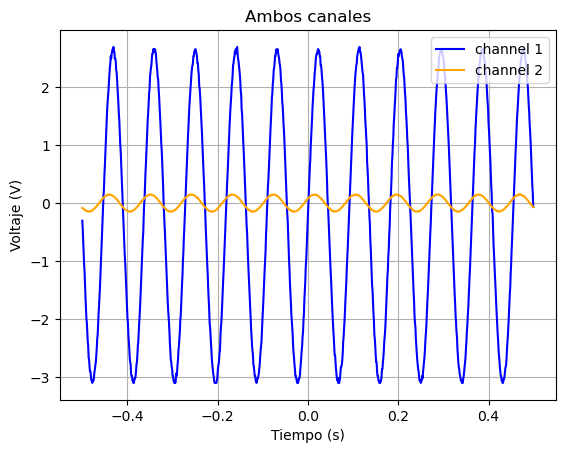

In [61]:
volt = amp_values[4]

t_1, v_1 = dic[f"{volt}V"][f"t_1"], dic[f"{volt}V"][f"V_1"]
t_2, v_2 = dic[f"{volt}V"][f"t_2"], dic[f"{volt}V"][f"V_2"]


plt.plot(t_1,v_1, label = "channel 1", color = "b")
plt.plot(t_2,v_2, label = "channel 2", color = "orange")
plt.xlabel("Tiempo (s)")
plt.ylabel("Voltaje (V)")
plt.title("Ambos canales")
plt.legend(loc = "upper right")
plt.grid()
plt.show()

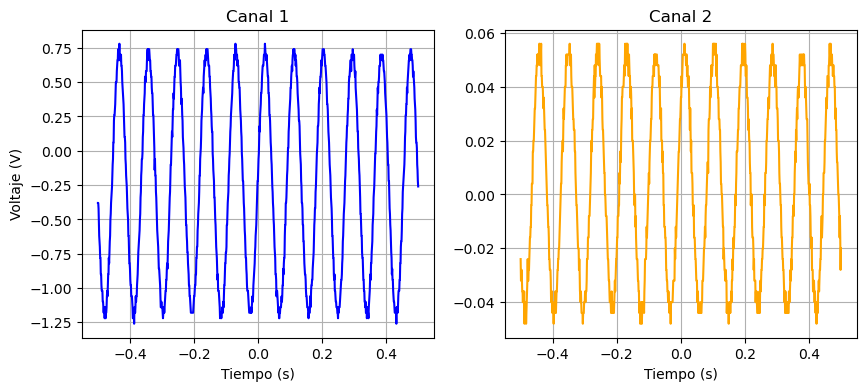

In [63]:
volt = amp_values[0]
channel = 1
t_1, v_1 = dic[f"{volt}V"][f"t_1"], dic[f"{volt}V"][f"V_1"]
t_2, v_2 = dic[f"{volt}V"][f"t_2"], dic[f"{volt}V"][f"V_2"]


fig, axs = plt.subplots(ncols = 2, figsize = (10,4))
axs[0].plot(t_1,v_1, color = "b")
axs[0].set_xlabel("Tiempo (s)")
axs[1].plot(t_2,v_2, color = "orange")
axs[1].set_xlabel("Tiempo (s)")
axs[0].set_ylabel("Voltaje (V)")
axs[0].set_title("Canal 1")
axs[0].grid()
axs[1].set_title("Canal 2")
axs[1].grid()
plt.show()

## Barrido en offset

In [17]:
offs_values = np.linspace(0,3.5,15)
dic = {}
for offset in offs_values:
    # Formato para pasar la amplitud: "AMP {valor_amplitud} {formato de unidad, VP:VPP, VR:VRMS}"
    # Cambiamos la amplitud
    func.write(f"OFFS {offset}")
    print(f"El offset cambio a {offset} V")
    
    # Cambiamos la escala de tensión
    
    osc.write("TRIGGER:MAIN SetLevel")
    time.sleep(3)
    
    
    
    t_1, v_1 = medir_canal(1)
    
    t_2, v_2 = medir_canal(2)
    dic[f"{offset}V"] = {"t_1":t_1, "V_1":v_1, "t_2":t_2, "V_2": v_2}

print("\n Terminó el barrido")

El offset cambio a 0.0 V
El offset cambio a 0.25 V
El offset cambio a 0.5 V
El offset cambio a 0.75 V
El offset cambio a 1.0 V
El offset cambio a 1.25 V
El offset cambio a 1.5 V
El offset cambio a 1.75 V
El offset cambio a 2.0 V
El offset cambio a 2.25 V
El offset cambio a 2.5 V
El offset cambio a 2.75 V
El offset cambio a 3.0 V
El offset cambio a 3.25 V
El offset cambio a 3.5 V

 Terminó el barrido


In [80]:
print(dic)

{'-2.0V': {'t_1': array([-0.5  , -0.499, -0.498, ...,  0.497,  0.498,  0.499]), 'V_1': array([ 0.8 ,  0.8 ,  0.72, ..., -1.2 , -1.2 , -1.28]), 't_2': array([-0.5  , -0.499, -0.498, ...,  0.497,  0.498,  0.499]), 'V_2': array([-9. , -7.8, -7. , ..., -9.8, -9.4, -9.8])}, '-1.5V': {'t_1': array([-0.5  , -0.499, -0.498, ...,  0.497,  0.498,  0.499]), 'V_1': array([-5.2 , -3.12, -3.28, ..., -5.28, -5.28, -5.2 ]), 't_2': array([-0.5  , -0.499, -0.498, ...,  0.497,  0.498,  0.499]), 'V_2': array([-9.8, -9.8, -9.4, ..., -9.4, -9.8, -9.4])}, '-1.0V': {'t_1': array([-0.5  , -0.499, -0.498, ...,  0.497,  0.498,  0.499]), 'V_1': array([-2.4 , -2.24, -2.24, ..., -4.24, -4.24, -4.32]), 't_2': array([-0.5  , -0.499, -0.498, ...,  0.497,  0.498,  0.499]), 'V_2': array([-9.4, -9.8, -9.8, ..., -9.4, -9. , -9.8])}, '-0.5V': {'t_1': array([-0.5  , -0.499, -0.498, ...,  0.497,  0.498,  0.499]), 'V_1': array([-1.2 , -1.2 , -1.2 , ..., -3.12, -3.28, -3.28]), 't_2': array([-0.5  , -0.499, -0.498, ...,  0.497,

In [19]:
pickle.dump(dic, open('Barrido en offsets a 0.2 V de amp.pickle', 'wb'))

## Barrido en frecuencias

In [64]:
freq_list = np.linspace(9000, 11000, 15)

for freq in freq_list:
    
    func.write(f"FREQ {freq}")
    print(f"La frecuencia cambió a {freq}")
    time.sleep(10)

La frecuencia cambió a 9000.0
La frecuencia cambió a 9142.857142857143
La frecuencia cambió a 9285.714285714286
La frecuencia cambió a 9428.57142857143
La frecuencia cambió a 9571.42857142857
La frecuencia cambió a 9714.285714285714
La frecuencia cambió a 9857.142857142857
La frecuencia cambió a 10000.0
La frecuencia cambió a 10142.857142857143
La frecuencia cambió a 10285.714285714286
La frecuencia cambió a 10428.57142857143
La frecuencia cambió a 10571.428571428572
La frecuencia cambió a 10714.285714285714
La frecuencia cambió a 10857.142857142857
La frecuencia cambió a 11000.0
